# <center> MSBA 6461: Advanced AI for Business Applications </center>
<center> Spring 2024, Mochen Yang </center>

## <center> Introduction to Reinforcement Learning and the Bandit Model </center>

# Table of contents
1. [What is Reinforcement Learning?](#intro)
    - [Definition of RL](#definition)
    - [Applications of RL](#application)
    - [Exploration vs. Exploitation](#explore_exploit)
1. [Terminology and Notation](#notation)
1. [The Bandit Model](#bandit)
    - [What's a Bandit and Why do we Care?](#define_bandit)
    - [Formal Setup of Bandit](#setup_bandit)
    - [Bandit Simulation](#simulation_bandit)
1. [Solving the Bandit Model](#solve_bandit)
    - [Approach 1: Action-Value Method](#action_value)
        - [Greedy and Near-Greedy Strategies](#greedy)
        - [Upper-Confidence-Bound (UCB) Strategy](#UCB)
    - [Approach 2: Gradient Method](#gradient_ascend)
1. [(Optional) Contextual Bandit Model](#contextual_bandit)
    - [Example: Linear Contextual Bandit](#LinearCB)
1. [Additional Resources](#resource)

# What is Reinforcement Learning? <a name="intro"></a>

## Definition of RL <a name="definition"></a>

_"Reinforcement learning is learning what to do - how to map situations to actions - so as to maximize a numerical reward signal."_ - \[Sutton and Barto\] Chapter 1.1

A good way of understanding RL is to compare it against other types of machine learning:
- **Supervised learning** (i.e., predictive analytics): learning from data with labels, about how to make predictions;
- **Unsupervised learning** (i.e., exploratory analytics): learning from data without labels, about structures/patterns of the data;
- **Reinforcement learning**: learning from interactions, about how to act under what situations.

In a sense, RL is closer to how we (humans) learn various skills: No one is born with a csv file of data and labels. We learn by exploring and interacting with the world around us.

![How Do Babies Learn?](images/how_baby_learn.png)

<font color="blue">Comment: </font>In some cases, you might hear people define RL as "learning without data". While this highlights the fact that RL learns from interactions rather than some readily available dataset, it can also be a bit misleading. RL needs data (in particular, actions and their rewards) to learn. However, the data is "generated" as the result of interactions. This will become clear once you start learning specific RL models and solutions.

## Applications of RL <a name="application"></a>

Some common applications of RL:
1. **Strategic game play**: This is perhaps the most famous applications of RL, owning largely to the success of AlphaGo
    - Playing board game: [AlphaGo](https://deepmind.com/research/case-studies/alphago-the-story-so-far), [AlphaZero](https://deepmind.com/blog/article/alphazero-shedding-new-light-grand-games-chess-shogi-and-go);
    - Playing Atari games: [Agent57](https://deepmind.com/blog/article/Agent57-Outperforming-the-human-Atari-benchmark);
    - Playing StarCraft: [AlphaStar](https://deepmind.com/blog/article/AlphaStar-Grandmaster-level-in-StarCraft-II-using-multi-agent-reinforcement-learning).
2. **Robotics**: For example, [robotic assembly in manufactoring](https://medium.com/pytorch/robotic-assembly-using-deep-reinforcement-learning-dfd9916c5ad7).
3. **Control**: This may be less acknowledged because it's less eye-catching than game playing. However, it may be the most prevalent and natural domain for RL applications. In fact, the fundamental theories and algorithms of RL mostly come from control theory (e.g., Markov process, dynamical systems, Bellman equation, dynamic programming, ...). RL is nothing new for people working in supply chain management and operations research.
4. **Large Language Models**: Reinforcement Learning from Human Feedback ([RLHF](https://en.wikipedia.org/wiki/Reinforcement_learning_from_human_feedback)) can help calibrate LLMs to better align with human preferences.

## Exploration vs. Exploitation <a name="explore_exploit"></a>

Just like the issue of overfitting and generalization is fundamental to supervised learning, the _tradeoff between exploration vs. exploitation_ is fundamental to RL. 

In non-rigorous languages:
- **Exploration** means trying out different possible actions to see which one(s) work better;
- **Exploitation** means keeping taking the action that appears to be the best based on currently available information;
- Too much exploration is wasteful - life is short, time is money;
- Too much exploitation can be myopic - maybe there is a much better option that you haven't tried;
- <font color="blue">Balancing exploration and exploitation is the central theme of most RL algorithms.</font>

# Terminology and Notation <a name="notation"></a>

RL uses a different set of terminologies than predictive/exploratory machine learning. In particular, RL is often described using an agent-environment framework.

![The Agent-Environment Framework](images/agent_environment.jpg)

Let's look at each component:
- **Agent** is the decision-maker who takes certain **action** in a given situation;
- **Environment** contains everything outside the agent. It is what the agent interacts with.
- In response to the agent's action, the environment produces a **reward**. The agent tries to learn from the reward feedback to figure out what's the best action(s);
- The environment is characterized by its **states**, which, roughly speaking, are the "situations" that the agent is facing. The states may change as a result of the agent's actions, and the states also affect the agent's actions;
- Each action that the agent can take has certain **value**, which describes how good it is in achieving high reward;
- A mapping between the agent's actions and the environment's states is called the **policy**. RL algorithms are trying to learn **optimal policy** from interactions.

As an example, let's think about driving (in a highly simplified manner):
- Agent: the driver;
- Environment: the road and other vehicles around the focal car;
- Action: step on gas / break, move steering wheel;
- Reward: a positive reward if the car moves in the desired direction / speed without accident. A (large) negative reward otherwise;
- States: the situations of the road (e.g., speed limit, ice / snow) and other surrounding vehicles (e.g., their speeds and movements);
- Value: how useful is each action in achieving higher reward, which can also depend on the states. For example, step on gas when there is a car right in front of you has large negative value; the same action can have positive value if the road is clear and you are driving below speed limit;
- Policy: a mapping between the states of the environment and what action(s) to take.

# The Bandit Model <a name="bandit"></a>

## What's a Bandit and Why do we Care? <a name="define_bandit"></a>

A (one-arm) bandit is a slot machine. Every time you pull the arm, there is a certain chance you will win a big reward (jackpot) or a small reward.

![bandit](images/bandit.jpg)

[image credit](https://www.amazon.com/Armed-Bandit-Slot-Machine-Bank/dp/B001KYV9DW)

The bandit that we consider can have $k$ arms - it is called a **multi-arm bandit (MAB)**. In every round, you will choose one of the $k$ arms to pull, and will get a certain reward. Your goal is to maximize your total reward after $T$ rounds.

**Why do we care about the bandit model in RL?**
- It is one of the simplest form of RL problem, where the environment is "static", i.e., the state of the bandit machine (i.e., the reward distributions of its arms) is fixed and do not change as a result of your action;
- Therefore, it helps provide a clear example of how reward feedback shapes the agent's action and behavior;
- It also clearly highlights the tradeoff between exploration and exploitation, as you will see later.

## Formal Setup of Bandit <a name="setup_bandit"></a>

Suppose we have a $k$-arm bandit, and the arms are indexed by $\{1,\ldots, k\}$. Each arm $i$ has a true expected reward that does not change over time (i.e., stationary), which we call $r_i$, and the realized reward every time it is pulled follows a normal distribution $N(r_i, \sigma^2_i)$. The true expected reward and its variance are unknown (otherwise the bandit problem is trivial - just keep pulling the arm with highest reward).

The agent, at each round $t$, will choose one of the $k$ arms to pull. We denote the agent's action as $A_t$, which is simply the index of an arm. The agent receives reward $R_{t+1}$ as a result.

The agent's action $A_t$ has a true value, which reflects how good it is:
$$q(a) = \mathbb{E}(R_{t+1}|A_t = a) = r_a$$

However, since the true reward of each arm is unknown, we never really know $q(a)$ - we can only hope to somehow estimate it (discussed later).

## Bandit Simulation <a name="simulation_bandit"></a>

We simulate the $k$-arm bandit discussed above and later on use this simulation to evaluate the performance of different solution strategies.

In [1]:
# import packages
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Let's consider a 10-arm bandit, and suppose the agent plays the bandit machine for 1000 rounds in total
k = 10
T = 1000
# First, simulate the true expected reward, r_i, of each arm, based on a standard normal (you can pick any distribution you want)
# set a seed so the results are reproducible
np.random.seed(1234)
true_rewards = np.random.normal(size = k)
print(true_rewards)

f"Average reward is {np.mean(true_rewards)}, Best arm reward is {max(true_rewards)}."

[ 0.47143516 -1.19097569  1.43270697 -0.3126519  -0.72058873  0.88716294
  0.85958841 -0.6365235   0.01569637 -2.24268495]


'Average reward is -0.14368349244677692, Best arm reward is 1.4327069684260973.'

In [3]:
# Every time an arm is pulled, a reward is produced by random drawing from N(r_i, 1)
# Define a function for convenience:
def pull(arm_ind):
    return np.random.normal(loc = true_rewards[arm_ind], scale = 1)

# Example, pull on the third arm
pull(2)

2.5827426931459154

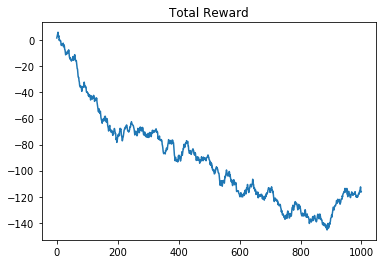

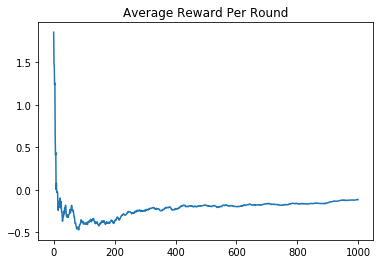

In [4]:
# As a naive baseline, let's try pulling the arms completely randomly
reward_random = []
sumreward_random = []
avereward_random = []
for t in range(T):
    # every time, randomly pull an arm
    arm = np.random.randint(low = 0, high = 10)
    reward_random.append(pull(arm))
    # record sum and average reward up to this round
    sumreward_random.append(np.sum(reward_random))
    avereward_random.append(np.mean(reward_random))

# Let's plot the sum and average reward over 1000 rounds
plt.plot(sumreward_random)
plt.title("Total Reward")
plt.show()

plt.plot(avereward_random)
plt.title("Average Reward Per Round")
plt.show()
# As you can imagine, it is pretty bad...
# Next time you are in a casino, don't just pull the machines randomly

# Solving the Bandit Model: Two Approaches <a name="solve_bandit"></a>

Balancing exploration and exploitation is the key to solving the bandit model. If one explores too much (e.g., keeps trying different arms), one may waste too many rounds on arms that do not produce high rewards. Conversely, if one exploits the current best arm too much and loses sight of the fact that some other arm might be even better, the outcome can also be suboptimal.

Below we discuss several solution strategies to the bandit problem. They all try to systematically trade off exploration vs. exploitation.

## Approach 1: Action-Value Method <a name="action_value"></a>

Recall that the true value of an action $a$ is an unknown quantity that we call $q(a)$. If we know $q(a)$, then the bandit problem becomes trivial - we will keep pulling the arm $a^* = \arg\max q(a)$. Even though $q(a)$ is generally unknown, we can still try to **estimate it from historical interactions and rewards**, and take actions accordingly - this is the key idea behind action-value method.

Specifically, denote $Q_t(a)$ as our _estimation_ of $q(a)$ based on interactions in the previous $t-1$ rounds. A simple and straightforward way to estimate $Q_t(a)$ is:
$$Q_t(a) = \frac{\sum_{i=1}^{t-1} R_i \mathbb{1}_{A_i = a}}{\sum_{i=1}^{t-1} \mathbb{1}_{A_i = a}}$$
where $\mathbb{1}$ is the indicator function and $\mathbb{1}_{A_i = a}$ equals 1 if action $A_i$ is $a$ and 0 otherwise. Intuitively, this is estimating $Q_t(a)$ as the **average realized reward of action $a$** in the previous rounds.

Based on the estimated $Q_t(a)$, there are multiple ways we can choose the next action $A_t$, which we discussed as follows.

In [5]:
# Let's implement the estimation of Q_t(a) as a function
# This is an incremental implementation, i.e., we update the Q_t(a) values every time a new action is taken
def value_est(curr_values, counter, action, reward):
    # curr_values stores the current estimate of Q_t(a)
    # counter keeps a record of how many times each arm has been pulled
    # action and reward are the next action and observed reward
    curr_values[action] = (curr_values[action]*counter[action] + reward) / (counter[action] + 1)
    counter[action] += 1
    return curr_values, counter

# Try it out
curr_values = [0,0,0]  # initial values
counter = [0,0,0]  # initialize counter
for action, reward in [(1,0.5), (0,1), (1,-1)]:
    curr_values, counter = value_est(curr_values, counter, action, reward)
    print(curr_values)

[0, 0.5, 0]
[1.0, 0.5, 0]
[1.0, -0.25, 0]


### Greedy and Near-Greedy Strategies <a name="greedy"></a>

The most straightforward strategy is to take action $A_t$ based on the largest $Q_t(a)$, i.e., the best arm so far (according to our estimates). That is
$$A_t = \arg\max_a Q_t(a)$$
This is a **greedy** strategy that only exploits the current best arm with no interest of exploration. Let's see how it does.

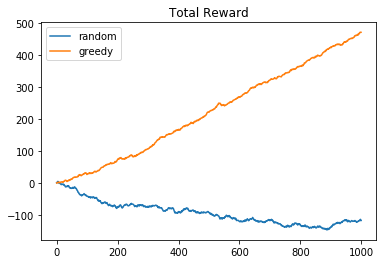

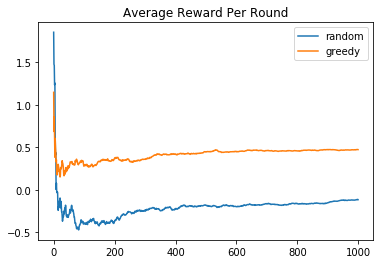

In [8]:
# Greedy strategy
curr_values = [0]*k  # initial values
counter = [0]*k  # initialize counter
reward_greedy = []
sumreward_greedy = []
avereward_greedy = []
for t in range(T):
    # every time, pull the current best arm
    arm = np.argmax(curr_values)
    reward = pull(arm)
    reward_greedy.append(reward)
    # record sum and average reward up to this round
    sumreward_greedy.append(np.sum(reward_greedy))
    avereward_greedy.append(np.mean(reward_greedy))
    # update curr_values
    curr_values, counter = value_est(curr_values, counter, arm, reward)

# Let's plot the sum and average reward over 1000 rounds
plt.plot(sumreward_random)
plt.plot(sumreward_greedy)
plt.title("Total Reward")
plt.legend(["random", "greedy"])
plt.show()

plt.plot(avereward_random)
plt.plot(avereward_greedy)
plt.title("Average Reward Per Round")
plt.legend(["random", "greedy"])
plt.show()

In [9]:
# check out the values and counter. What do you see? What does it mean?
print(curr_values)
print(counter)

[0.4722047665320357, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1000, 0, 0, 0, 0, 0, 0, 0, 0, 0]


It's already much better than randomly pulling arms! <font color="blue">Can we do better? Yes we can!</font>

Note that the greedy approach does not explore at all - it is extremely myopic and only takes what's best for now. In this case, it keeps pulling the first arm and never explores the other arms. But this is sub-optimal, because the first arm is not the best. To add in a bit of exploration, a simple approach is to _initialize the value of each action to a (somewhat large) positive number_. This way, an arm that's not tried before may appear more attractive. This is called **greedy approach with optimistic initialization**. Let's see how it does.

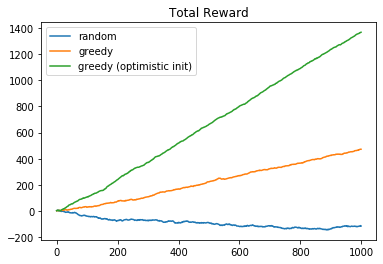

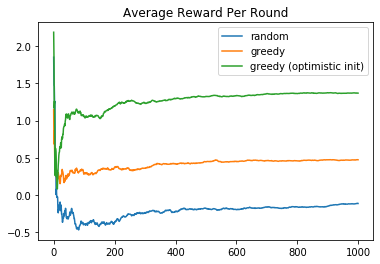

In [14]:
# Greedy strategy with optimistic initialization
curr_values = [2]*k  # optimistic initial values
counter = [0]*k  # initialize counter
reward_greedy_optint = []
sumreward_greedy_optint = []
avereward_greedy_optint = []
for t in range(T):
    # every time, pull the current best arm
    arm = np.argmax(curr_values)
    reward = pull(arm)
    reward_greedy_optint.append(reward)
    # record sum and average reward up to this round
    sumreward_greedy_optint.append(np.sum(reward_greedy_optint))
    avereward_greedy_optint.append(np.mean(reward_greedy_optint))
    # update curr_values
    curr_values, counter = value_est(curr_values, counter, arm, reward)

# Let's plot the sum and average reward over 1000 rounds
plt.plot(sumreward_random)
plt.plot(sumreward_greedy)
plt.plot(sumreward_greedy_optint)
plt.title("Total Reward")
plt.legend(["random", "greedy", "greedy (optimistic init)"])
plt.show()

plt.plot(avereward_random)
plt.plot(avereward_greedy)
plt.plot(avereward_greedy_optint)
plt.title("Average Reward Per Round")
plt.legend(["random", "greedy", "greedy (optimistic init)"])
plt.show()

In [15]:
# check out the values and counter. What do you see? What does it mean?
print(curr_values)
print(counter)

[0.8962138544764029, -0.2156073054699501, 1.3885297637204044, -1.9700280929504033, -1.5148706620934025, 1.0915368160764094, -0.44366979896299197, -1.8178904183641489, 1.0010438584587038, -1.5761587647075292]
[3, 1, 982, 1, 1, 7, 1, 1, 2, 1]


Much better now. You can see that (1) every arm is tried at least once, and (2) the third arm (which happens to be the best) is pulled the most times.

Optimistic initialization is not the only way to encourage exploration. Alternatively, we can "force" the greedy algorithm to explore once in a while. This is often called a **$\varepsilon$-greedy strategy**. Specifically,

$$A_t = \begin{cases} \arg\max_a Q_t(a) &\text{with } 1-\varepsilon \text{ probability} \\
\text{randomly choose another action} & \text{with } \varepsilon \text{ probability} \end{cases}$$

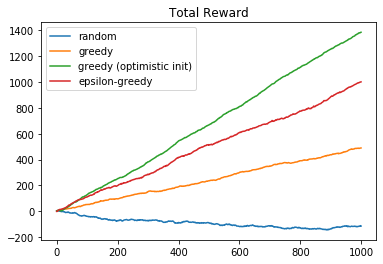

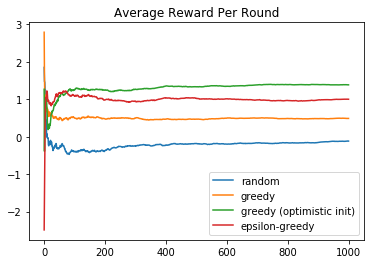

In [38]:
# Epsilon-Greedy strategy
curr_values = [0]*k  # initial values
counter = [0]*k  # initialize counter
eps = 0.2  # force to explore 20% of the time
reward_greedy_eps = []
sumreward_greedy_eps = []
avereward_greedy_eps = []
for t in range(T):
    # current best arm
    arm = np.argmax(curr_values)
    # throw a coin
    explore = np.random.binomial(1, eps)
    if explore:
        # randomly pull another arm
        arm = np.random.choice(np.setdiff1d(range(k), arm))
    reward = pull(arm)
    reward_greedy_eps.append(reward)
    # record sum and average reward up to this round
    sumreward_greedy_eps.append(np.sum(reward_greedy_eps))
    avereward_greedy_eps.append(np.mean(reward_greedy_eps))
    # update curr_values
    curr_values, counter = value_est(curr_values, counter, arm, reward)

# Let's plot the sum and average reward over 1000 rounds
plt.plot(sumreward_random)
plt.plot(sumreward_greedy)
plt.plot(sumreward_greedy_optint)
plt.plot(sumreward_greedy_eps)
plt.title("Total Reward")
plt.legend(["random", "greedy", "greedy (optimistic init)", "epsilon-greedy"])
plt.show()

plt.plot(avereward_random)
plt.plot(avereward_greedy)
plt.plot(avereward_greedy_optint)
plt.plot(avereward_greedy_eps)
plt.title("Average Reward Per Round")
plt.legend(["random", "greedy", "greedy (optimistic init)", "epsilon-greedy"])
plt.show()

In [39]:
# check out the values and counter. What do you see? What does it mean?
print(curr_values)
print(counter)

[0.14097361393915073, -1.0739364601314483, 1.382115787520225, -0.3072651164551624, -0.7318168881710683, 0.9260143992418988, 0.8391319013632896, -0.8383104254748551, 0.23283960273913792, -2.667170899507815]
[19, 26, 782, 21, 22, 27, 30, 19, 27, 27]


Also pretty good! Note that the relative performance between greedy with optimistic initialization and $\varepsilon$-greedy strategies depends on the problem setup and how each strategy is parameterized (e.g., how initialization is done and the value of $\varepsilon$).

### Upper-Confidence-Bound (UCB) Strategy <a name="UCB"></a>

As you have seen above, winning the bandit game really depends on a smart way to trade off exploration vs. exploitation. Besides setting optimistic initial values and force exploration probabilistically, we can also try to _strategically explore the actions that are under-explored_. This is the key idea behind the UCB strategy. More specifically, UCB picks the action according to
$$A_t = \arg\max_a \left\{Q_t(a) + c \cdot \sqrt{\frac{\ln t}{N_t(a)}} \right\}$$
where $c$ is a constant that controls the "aggressiveness" of exploration, and $N_t(a)$ is the number of times that action $a$ has been taken in the previous $t-1$ rounds (i.e., the same as $\sum_{i=1}^{t-1} \mathbb{1}_{A_i = a}$).

Here's the intuition for this formula:
- Fixing the number of rounds $t$, a smaller $N_t(a)$ means that action $a$ has not been tried a lot before. For exploration purpose, we should try it more by manually bumping up its value;
- Fixing $N_t(a)$, a larger $t$ means that action $a$ has not been tried very frequently/intensely before. Again, we should try it more;
- Having a larger $c$ means that we are more aggressive in trying out under-explored actions;
- If $N_t(a) = 0$, then $\sqrt{\frac{\ln t}{N_t(a)}} \rightarrow \infty$, which means that action $a$ must be tried. This also ensures that all actions are tried at least once.

UCB is inherently an _optimistic_ strategy, because it "believes" that exploring previously under-explored actions is a good thing that should be encouraged. In a sense, UCB is "risk-seeking".

<font color="blue">Where does the adjustment term $\sqrt{\frac{\ln t}{N_t(a)}}$ come from? </font>There is actually mathematical justification for it. If you are interested, check out this blog: [The Multi-Armed Bandit Problem and Its Solutions](https://lilianweng.github.io/lil-log/2018/01/23/the-multi-armed-bandit-problem-and-its-solutions.html#upper-confidence-bounds).

In [36]:
# let's define a function to calculate the adjusted values under UCB
def ucb_calc(curr_values, t, counter, c):
    ucb_values = [0]*len(curr_values)
    for i in range(k):
        if counter[i] == 0:
            ucb_values[i] = curr_values[i] + 9999.99   # some very large number to represent "infinity"
        else:
            ucb_values[i] = curr_values[i] + c * np.sqrt(np.log(t) / counter[i])
    return ucb_values

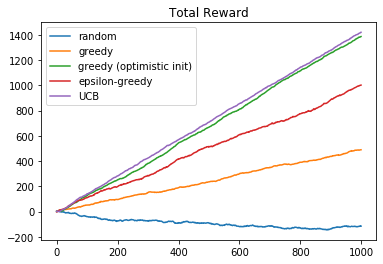

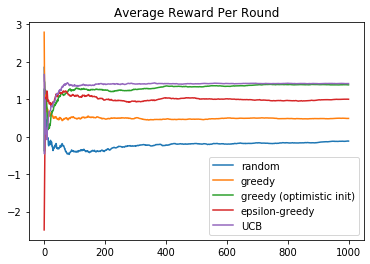

In [46]:
# UCB
curr_values = [0]*k  # initial values
counter = [0]*k  # initialize counter
c = 0.1  # mildly exploration
#c = 10.0  # very aggressive exploration
reward_ucb = []
sumreward_ucb = []
avereward_ucb = []
for t in range(T):
    # do the UCB value adjustments
    ucb_values = ucb_calc(curr_values, t+1, counter, c)
    # current best arm
    arm = np.argmax(ucb_values)    
    reward = pull(arm)
    reward_ucb.append(reward)
    # record sum and average reward up to this round
    sumreward_ucb.append(np.sum(reward_ucb))
    avereward_ucb.append(np.mean(reward_ucb))
    # update curr_values
    curr_values, counter = value_est(curr_values, counter, arm, reward)

# Let's plot the sum and average reward over 1000 rounds
plt.plot(sumreward_random)
plt.plot(sumreward_greedy)
plt.plot(sumreward_greedy_optint)
plt.plot(sumreward_greedy_eps)
plt.plot(sumreward_ucb)
plt.title("Total Reward")
plt.legend(["random", "greedy", "greedy (optimistic init)", "epsilon-greedy", "UCB"])
plt.show()

plt.plot(avereward_random)
plt.plot(avereward_greedy)
plt.plot(avereward_greedy_optint)
plt.plot(avereward_greedy_eps)
plt.plot(avereward_ucb)
plt.title("Average Reward Per Round")
plt.legend(["random", "greedy", "greedy (optimistic init)", "epsilon-greedy", "UCB"])
plt.show()

In [47]:
# check out the values and counter. What do you see? What does it mean?
print(curr_values)
print(counter)

[0.7718383125304418, -2.5772148487367694, 1.4405981368028258, 0.18131691175840497, -0.7434648551050875, -1.0505406711923455, -0.7294307453815362, -0.08271645325076726, 0.8068037791811108, -2.1193503941660046]
[4, 1, 988, 1, 1, 1, 1, 1, 1, 1]


Note that UCB is almost as good as the previous best strategy (greedy with optimistic initialization), as the two lines are almost parallel in the total reward plot. Again, which strategy works best is dependent on problem setup and the configuration of each strategy.

<font color="red">Now try setting $c=10$ and see what happens.</font> What can we learn from it? <font color="blue">No exploration is bad, but too much exploration can also be bad.</font>

## Approach 2: Gradient Method <a name="gradient_ascend"></a>

The gradient method follows a different idea to solve the bandit problem. Rather than trying to estimate the value of different actions (i.e., $Q_t(a)$), the gradient method tries to **estimate the probability that each action should be taken**, and then revises these probability estimates in an iterative manner.

More specifically, the action probabilities are calculated via a softmax:
$$\Pr(A_t = a) = \frac{e^{H_t(a)}}{\sum_{b=1}^{k} e^{H_t(b)}} \doteq \pi_t(a)$$
Here, $H_t(a)$ can be thought of as a "preference score" for action $a$ at time $t$, and the notation $\pi_t(a)$ is commonly used in RL to represent the probability that action $a$ should be taken at time $t$.

Then, the preference scores $H_t(a)$ are learned based on reward feedback and updated after each interaction (each pull), in the following way: Suppose arm $A_t$ was pulled at time $t$ and received a reward $R_{t+1}$, then

$$H_{t+1}(A_t) = H_t(A_t) + \alpha (R_{t+1} - \overline{R_{t+1}})(1-\pi_t(A_t))$$
$$H_{t+1}(a) = H_t(a) - \alpha (R_{t+1} - \overline{R_{t+1}})\pi_t(a), \text{   for any } a \neq A_t$$
where $\alpha$ is a step size parameter and $\overline{R_{t+1}} = \frac{1}{t+1}\sum_{i=1}^{t+1} R_i$ is the average reward up to time $t+1$ (i.e., rewards associated with the first $t$ actions).

<font color="red">Why does this work?</font> Here's the intuition:
- If $R_{t+1} > \overline{R_{t+1}}$, i.e., the reward received as a result of action $A_t$ is better than average reward in the past, that means action $A_t$ is pretty good, and we should increase its probability.
- At the same time, we should decrease the probabilities of other actions (in favor of action $A_t$).

<font color="blue">This incremental update procedure should remind you of gradient descent!</font> In fact, it is exactly gradient descent. For a proof, see \[Sutton and Barto\] Chapter 2.8. It is referred to as "gradient ascend" in the textbook simply because we are _maximizing_ reward rather than minimizing some loss function.

In [15]:
# Let's implement Gradient method. For convenience, let's make a softmax function
def softmax(x):
    return np.exp(x)/sum(np.exp(x))

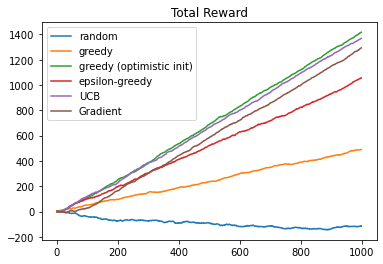

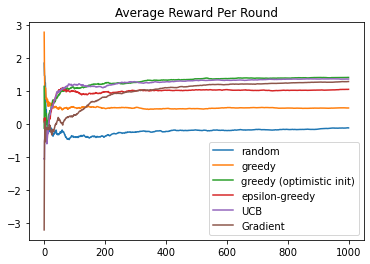

In [19]:
# Gradient method
H = [0]*k  # initial preference scores. Doesn't matter that much how you initialize them, as long as different actions have the same initial score
prob = softmax(H)  # initialize probabilities
alpha = 0.1  # step size

reward_gradient = []
sumreward_gradient = []
avereward_gradient = []
for t in range(T):
    # choose an arm based on probabilities
    arm = np.random.choice(range(k), p = prob)    
    reward = pull(arm)
    reward_gradient.append(reward)
    avereward = np.mean(reward_gradient)
    # record sum and average reward up to this round
    sumreward_gradient.append(np.sum(reward_gradient))
    avereward_gradient.append(avereward)
    # update prob
    for i in range(k):
        if i == arm:
            H[i] = H[i] + alpha*(reward - avereward)*(1-prob[i])
        else:
            H[i] = H[i] - alpha*(reward - avereward)*prob[i]
    prob = softmax(H)

# Let's plot the sum and average reward over 1000 rounds
plt.plot(sumreward_random)
plt.plot(sumreward_greedy)
plt.plot(sumreward_greedy_optint)
plt.plot(sumreward_greedy_eps)
plt.plot(sumreward_ucb)
plt.plot(sumreward_gradient)
plt.title("Total Reward")
plt.legend(["random", "greedy", "greedy (optimistic init)", "epsilon-greedy", "UCB", "Gradient"])
plt.show()

plt.plot(avereward_random)
plt.plot(avereward_greedy)
plt.plot(avereward_greedy_optint)
plt.plot(avereward_greedy_eps)
plt.plot(avereward_ucb)
plt.plot(avereward_gradient)
plt.title("Average Reward Per Round")
plt.legend(["random", "greedy", "greedy (optimistic init)", "epsilon-greedy", "UCB", "Gradient"])
plt.show()

In [20]:
# check out the final action probabilities
print(prob)

[1.46955848e-03 2.35675222e-04 9.91047782e-01 6.57907200e-04
 5.49321017e-04 1.74931868e-03 2.58973087e-03 7.13966588e-04
 6.99800573e-04 2.86939556e-04]


Again, it's doing a pretty decent job and correctly identifies the third arm as the most profitable.

# (Optional) Contextual Bandit Model <a name="contextual_bandit"></a>

Contextual bandit is a direct generalization of the basic bandit model, where the reward in each round depends not only on the action taken, but also on a _"context"_. More formally, this means that the expected reward of an action $a$, which we have denoted as $r_a$, is no longer a constant, but depends on the context $x$. Notationally, we can write $\mu(a|x)$ as the expected reward of arm $a$ in the presence of context $x$.

In a given round $t$, a particular context $x_t$ is observed, and the task is to discover a policy $\pi(x)$ that decides the arm to pull, in order to maximize the expected total reward:
$$
\mathbb{E}(Reward) = \sum_{t=1}^T \mu(a_t|x_t)
$$

The key of solving contextual bandit is to model the relationship between expected reward of an action and the context. 

## Example: Linear Contextual Bandit <a name="LinearCB"></a>

In a linear contextual bandit model, the expected reward of an arm is modeled as a linear function of the context:
$$
\mu(a | x) = x^T \theta_a
$$
where $\theta_a$ is a vector of weight parameters (same length as context) that is to be learned / estimated.

# Additional Resources <a name="resource"></a>

- A comprehensive blog post on multi-arm bandit and its solutions: [The Multi-Armed Bandit Problem and Its Solutions](https://lilianweng.github.io/lil-log/2018/01/23/the-multi-armed-bandit-problem-and-its-solutions.html);
- A technical treatment of bandit models [Introduction to Multi-Armed Bandits](https://arxiv.org/pdf/1904.07272.pdf)
- [A Tutorial on Thompson Sampling](https://arxiv.org/pdf/1707.02038.pdf)
- [The Ingredients of Real World Robotic Reinforcement Learning](https://bair.berkeley.edu/blog/2020/04/27/ingredients/#:~:text=In%20particular%2C%20with%20reinforcement%20learning,environment%20may%20not%20be%20known.);
- [Reinforcement learning in robotics](https://medium.com/@vmayoral/reinforcement-learning-in-robotics-d2609702f71b);